In [13]:
%reload_ext autoreload
%autoreload 2

In [14]:
ls *load*

biomag_download_info.ipynb  download_hcp_central.ipynb  download_output.txt


In [15]:
ls /mnt/hcp-meg/105923/

105923-head_mri-trans.fif  rest-run1-preproc-raw.fif
rest-run0-preproc-raw.fif  rest-run2-preproc-raw.fif


In [16]:
import copy as cp
import os.path as op
import mne

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

import hcp
from hcp import preprocessing as preproc
from hcp import io

from scipy.signal import welch
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [17]:
%matplotlib inline

In [18]:
# # def nb_render_brain():
from IPython.display import Image
from mayavi import mlab
mlab.options.offscreen = True
# brain = Brain("fsaverage", "rh", "inflated", subjects_dir='/home/ubuntu/freesurfer/subjects')
# brain.save_image('example2.png')


In [19]:
sns.set_style('ticks')

In [20]:
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
# matplotlib.rc('text', usetex='false') 

In [21]:
recordings_path = '/mnt/hcp-meg'
subject = '105923'

In [22]:
fname = op.join(recordings_path, subject, 'rest-run0-preproc-raw.fif')

In [23]:
raw = mne.io.read_raw_fif(fname)

Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.


<ipython-input-23-826c3e305aa6>:1: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


In [24]:
raw.load_data()

Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<Raw  |  rest-run0-preproc-raw.fif, n_channels x n_times : 248 x 749070 (368.2 sec), ~1.38 GB, data loaded>

In [25]:
%matplotlib inline

In [26]:
def _preprocess_raw(raw, hcp_params, ica_sel):
    # construct MNE annotations
    annots = hcp.read_annot(**hcp_params)
    bad_seg = (annots['segments']['all']) / raw.info['sfreq']
    annotations = mne.Annotations(
        bad_seg[:, 0], (bad_seg[:, 1] - bad_seg[:, 0]),
        description='bad')

    raw.annotations = annotations
    raw.info['bads'] += annots['channels']['all']
    raw.pick_types(meg=True, ref_meg=False)

    # read ICA and remove EOG ECG or keep brain components
    ica_mat = hcp.read_ica(**hcp_params)
    if ica_sel == 'ecg_eog':
        exclude = annots['ica']['ecg_eog_ic']
    elif ica_sel == 'brain':
        exclude = [ii for ii in range(annots['ica']['total_ic_number'][0])
                   if ii not in annots['ica']['brain_ic_vs']]

    preproc.apply_ica_hcp(raw, ica_mat=ica_mat, exclude=exclude)
    # add back missing channels
    raw = preproc.interpolate_missing(raw, **hcp_params)
    return raw

In [27]:
hcp_params = dict(subject=subject, hcp_path=op.join('/mnt', 'HCP'),
                  data_type='rest')

raw = _preprocess_raw(raw, hcp_params=hcp_params, ica_sel='ecg_eog')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/3-Restin/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Creating RawArray with float64 data, n_channels=248, n_times=749070
Current compensation grade : 0
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
    Computing dot products for 245 coils...
    Computing cross products for coils 245 x 3 coils...
    Preparing the mapping matrix...
    [Truncate at 84 missing 0.0001]


## works with with natural log

In [ ]:
%matplotlib inline
freqs, psd = welch(raw[100][0], nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear')
fmask = (freqs <= 4) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log(freqs[fmask][:, None]),
   np.log(psd.T[fmask]),
   )
frange = np.log(freqs[fmask].max()) - np.log(freqs[fmask].min())
print(frange)
plt.figure()
plt.plot(np.log(freqs), np.log(psd.T))
plt.plot(np.log(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log([0.01, 0.1, 1, 10, 100]),
                  [0.01, 0.1, 1, 10, 100])
sns.despine(trim=True)

## works with with decadic log

In [ ]:
freqs, psd = welch(raw[100][0] * 1e15, nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear', scaling='density')
    

In [ ]:
plt.plot(freqs[fmask])

In [ ]:
freqs, psd = welch(raw[100][0], nperseg=(2**15), fs=raw.info['sfreq'], detrend='linear',
                   scaling='spectrum', noverlap=0)
fmask = (freqs <= 4) & (freqs > 0)
fmask = (freqs <= 4) & (freqs > 0)
freqs = np.log10(freqs)
psd /= psd[:, 1]
psd = 20 * np.log10(psd)
lm = LinearRegression(normalize=False).fit(
   freqs[fmask][:, None],
   psd.T[fmask])

fit_line = lm.predict(freqs[fmask][:, None])
plt.figure()
plt.plot(freqs, psd.T)
plt.plot(freqs[fmask], fit_line, color='red', label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)

## beta estimates as a function of window length

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

In [ ]:
mean_squared_error(lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))

In [ ]:
for exp in [12, 13, 14, 15, 16, 17, 18]:
    n_fft = 2 ** exp
    freqs, psd = welch(raw[100][0], nperseg=(n_fft), fs=raw.info['sfreq'], detrend='constant',
                       noverlap=0)
    fmask = (freqs <= 2) & (freqs > 0)
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]),
       np.log10(psd.T[fmask]),
       )
    score = r2_score(
        lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    plt.figure()
    plt.plot(np.log10(freqs), np.log10(psd.T))
    fit_line = (lm.intercept_ - lm.coef_ * frange), lm.intercept_
    plt.plot(np.log10(freqs[fmask][[0, -1]]),
             fit_line, color='red',
             label='beta=%0.3f (nfft=%0.3f) r2=%0.3f' % (
                lm.coef_[0], 1. / raw.info['sfreq'] * n_fft, score))
    plt.legend(loc='best')
    plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
    sns.despine(trim=True)
    

## Use FFT without windowing

In [ ]:
(lm.intercept_ - (lm.coef_ * frange)), lm.intercept_

In [ ]:
from scipy import fft, fftpack

freqs = fftpack.fftfreq(len(raw[100][0][0]), raw.times[1] - raw.times[0])
freqs = freqs[:freqs.size/2]

psd = fftpack.fft(raw[100][0][0])
psd = np.abs(psd[:psd.size/2][None, :])

fmask = (freqs <= 2) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))

fit_line = np.array([lm.intercept_,
                     lm.intercept_ + lm.coef_ * frange])
offset = np.abs(np.diff(fit_line.ravel()))[0]
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         fit_line + offset, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)  

## an improved welch estimator

Use epoching functionality to get the good data segments, then apply windowing manually prior to FFT computation.
Shortcut: drop bad epochs, reconstruct raw data and then use the scipy function.

We see that with zero overlap the solutions are equivalent

In [ ]:
n_fft = 2**15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)

In [ ]:
raw2 = mne.io.RawArray(info=epochs.info, data=np.hstack(epochs.get_data()))

In [ ]:
print(raw.times.shape, raw2.times.shape)

In [ ]:
psd1, freqs = mne.time_frequency.psd_welch(raw, n_fft=n_fft, picks=[100], n_overlap=0)
psd2, freqs = mne.time_frequency.psd_welch(raw2, n_fft=n_fft, picks=[100], n_overlap=0)
psd3_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, picks=[100], n_overlap=0)
psd3 = psd3_epochs.mean(0)

In [ ]:
ls paper_figures/

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

fs = 18
axs[0].plot(10 * np.log(psd1.ravel()), 10 * np.log(psd2.ravel()),
            linewidth=0, marker='o', color='blue')
axs[0].set_title('classical welch', fontsize=fs)
axs[0].set_ylabel('pre-cleaned welch', fontsize=fs)

axs[1].plot(10 * np.log(psd3.ravel()), 10 * np.log(psd2.ravel()),
            linewidth=0, marker='o', color='orange')
axs[1].set_title('pre-cleaned welch', fontsize=fs)
axs[1].set_ylabel('epoched welch', fontsize=fs)

axs[2].plot(10 * np.log(psd1.ravel()), 10 * np.log(psd3.ravel()),
            linewidth=0, marker='o', color='red')

axs[2].set_title('classical welch', fontsize=fs)
axs[2].set_ylabel('epoched welch', fontsize=fs)
for ax in axs:
    ax.set_xlim(-810, -540)
    ax.set_ylim(-810, -540)
sns.despine(trim=True)

plt.show()
fig.savefig('paper_figures/check_welch_estimators.png', dpi=600)

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

fs = 18
axs[0].plot(np.log10(freqs), 10 * np.log10(psd1).T, label='classical', color='blue')
axs[1].plot(np.log10(freqs), 10 * np.log10(psd2).T, label='pre-cleaned', color='orange')
axs[2].plot(np.log10(freqs), 10 * np.log10(psd3).T, label='epoched', color='red')
[[l.set_fontsize(16) for l in ax.legend().get_texts()] for ax in axs]
for ii, ax in enumerate(axs):
    if ii == 2:
        ax.set_xlabel('Frequency [Hz]', fontsize=fs)
    ax.set_ylabel('Power', fontsize=fs)
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_ylim(-300, -240)
    ax.set_xlim(np.log10(0.08), np.log10(100))

sns.despine(trim=True)
fig.savefig('paper_figures/check_welch_estimators_power.png', dpi=600)

In [ ]:
lm.coef_.mean()

In [ ]:
lm.intercept_.mean(), (lm.intercept_.mean() + lm.coef_.mean() * frange) + frange

In [ ]:
np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())

In [ ]:
np.log10(freqs[fmask].max() - freqs[fmask].min())

In [ ]:
fit_line = np.array([lm.intercept_.mean(),
                         lm.intercept_.mean() + lm.coef_.mean() * frange])

In [ ]:
np.log10(freqs[fmask])

In [ ]:
vals = list()

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()

colors = [plt.cm.viridis(ii) for ii in
          np.linspace(0, 1, len(axes))]

for i_ax, (exp, ax, color) in enumerate(zip(
        [12, 13, 14, 15, 16, 17], axes, colors)):
    n_fft = 2 ** exp
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = 10 * np.log10(psd_epochs.mean(0))
    
    fmask = (freqs <= 2) & (freqs > 0)
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]), psd.T[fmask])
    scores = [r2_score(x, y) for x, y in zip(
              lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
    vals.append((n_fft, scores, lm.coef_.ravel(), freqs[fmask][0]))
    psd_std = psd.std(0).T
    psd_mean = psd.mean(0).T
    
    ax.fill_between(np.log10(freqs), (psd_mean + psd_std).ravel(),
                                     (psd_mean - psd_std).ravel(),
                    color=color, alpha=0.3)
    ax.plot(np.log10(freqs), psd_mean, color=color,
            label='NFFT={}'.format(n_fft), linewidth=3)

    fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
    ax.plot(np.log10(freqs[fmask]),
             fit_line, color='red',
             label='beta=%0.3f (r2=%0.3f)' % (
                lm.coef_.mean(), np.mean(scores)),
            linewidth=2, linestyle='--')
    if i_ax in [3, 4, 5]:
        ax.set_xlabel('Frequency [Hz]', fontsize=18)
    if i_ax in [0, 3]:
        ax.set_ylabel('Power', fontsize=18)
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_xlim(np.log10(0.05), np.log10(100))
    ax.set_ylim(-295, -240)
    for tt in ax.legend(loc='lower left').get_texts():
        tt.set_fontsize(16)


sns.despine(trim=True)
fig.savefig('paper_figures/check_nfft_power_spectrum.png', dpi=600)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

bplots = [axs[0].boxplot([v[2] for v in vals]),
          axs[1].boxplot([v[1] for v in vals])]
axs[0].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[1].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[0].set_xlabel('Lowest frequency [Hz]', fontsize=20)
axs[1].set_xlabel('Lowest frequency [HZ]', fontsize=20)
axs[0].set_ylabel(r'powerlas exponent $\beta$ ', fontsize=20)
axs[1].set_ylabel(r'explained variance [$r^2$]', fontsize=20)
axs[0].set_xlim(0.5, 6.5)
axs[1].set_xlim(0.5, 6.5)
axs[1].set_ylim(-11, 1.5)


all_colors = [[plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))],
              [plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))]]

[axs[1].plot(42, 42, label='NFFT=%d' % v[0], color=c, marker='o')
 for v, c in zip(vals, all_colors[1])]
lg = axs[1].legend(loc='best')
[tt.set_fontsize(14) for tt in lg.get_texts()]

for bb, bplot in enumerate(bplots, 0):
    colors = all_colors[bb]
    for k, elems in bplot.items():
        for jj, el in enumerate(elems):
            if len(elems) == len(colors):
                this_colors = colors[:]
            else:
                this_colors = sum([[c, c] for c in colors], [])
            if hasattr(el, 'set_color'):
                el.set_color(this_colors[jj])
                el.set_linewidth(3)
sns.despine(trim=True)

fig.savefig('paper_figures/paper_fig_beta_est_choice.png', dpi=600)

## Checkout source localization and beta estimation

The firt task here will be to map the broadband signalfrom which we extract slow cortical potentials and the bandpass filtered hilbert alpha time course into source space such that memory does not explode and the corresponding powerlaw exponent can be computed.

We can stick with our epochs estimator here and map data epoch by epoch into the source space to then aggregate the data. Once this is done we can estimate powerlaw exponents all over the cortex without ROI-based approach.

The procedure is the same, whether we use the broadband data ore hilbert transformed data.
In the latter case the inverse operator will be applied to complex valued raw data.

### some concerns

- regularization parameter can have a strong impact on power estimates using MNE, the spatial SNR can be effectively much better than snr=1. Range 1-15 to be considered.
- covariance: frequency specific noise ... should probably match the signal projected.


In [ ]:
raw_noise = hcp.read_raw(data_type='noise_empty_room', subject='105923', hcp_path='/mnt/HCP')

In [ ]:
from scipy.signal.spectral import get_window

In [ ]:
from scipy import fft, fftpack

x = raw[100][0][0]
n_samples = x.shape[-1]
# win = get_window('hanning', n_samples)

psd = fftpack.fft(x, n=2**15)

n_samples = psd.shape[-1]
freqs = fftpack.fftfreq(psd.shape[-1], raw.times[1] - raw.times[0])
psd = np.abs(psd[:psd.size/2][None, :]) ** 2
freqs = freqs[:freqs.size/2]

fmask = (freqs <= 2) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)  

## check how filter params drive alpha envelope slope

In [ ]:
ls

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.ravel()
n_fft = 2 ** 15
filtparams = [(7, 13), (8, 12), (9, 11)]
colors = [plt.cm.viridis(cc) for cc in np.linspace(0, 1, len(filtparams))] 
for ii, (fmin, fmax) in enumerate(filtparams):
    raw_hil = raw.copy().filter(fmin, fmax, picks=[100])
    raw_hil.apply_hilbert(picks=[100], envelope=True)
    freqs, psd = welch(raw_hil[100][0], nperseg=(n_fft), fs=raw_hil.info['sfreq'],
                       detrend='constant',
                       noverlap=0)
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0, picks=[100],
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = psd_epochs.mean(0)
    axes[0].plot(np.log10(freqs), np.log10(psd.T),
                 color=colors[ii], label='{}-{}'.format(fmin, fmax), linewidth=3);
ax = axes[0]
for tt in ax.legend(loc='best').get_texts():
    tt.set_fontsize(18)
ax.set_xlabel('log(frequency)', fontsize=20)
ax.set_ylabel('power [dB]', fontsize=20)
ax.annotate('(A)', xy=(np.log10(0.1), -27), fontsize=24)
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10(0.08), np.log10(100))

ax.set_ylim(-36, -25)

filtparams = [12, 13, 14, 15]
colors = [plt.cm.viridis(cc) for cc in np.linspace(0, 1, len(filtparams))] 
for ii, (exp) in enumerate(filtparams):
    raw_hil = raw.copy().filter(l_freq=8, h_freq=12, filter_length=2 ** exp, picks=[100])
    raw_hil.apply_hilbert(picks=[100], envelope=True)
    freqs, psd = welch(raw_hil[100][0], nperseg=(n_fft), fs=raw_hil.info['sfreq'],
                       detrend='constant',
                       noverlap=0)

    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0, picks=[100],
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = psd_epochs.mean(0)
    axes[1].plot(np.log10(freqs), np.log10(psd.T),
                 color=colors[ii], label='{}'.format(2**exp), linewidth=3);
ax = axes[1]
for tt in ax.legend(loc='best').get_texts():
    tt.set_fontsize(18)
ax.set_xlabel('log(frequency)', fontsize=20)
ax.set_ylabel('power [dB]', fontsize=20)
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10(0.08), np.log10(100))
ax.set_ylim(-36, -25)
ax.annotate('(B)', xy=(np.log10(0.1), -27), fontsize=24)
sns.despine(trim=True)
fig.savefig('paper_figures/check_filter_params_on_alpha.png', dpi=600)

# Checkout peak estimation with kernels an diff trick

In [ ]:
n_fft = 2 ** 15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)


In [ ]:
from astropy.convolution import convolve, Gaussian1DKernel

In [ ]:
np.log10(psd)

In [ ]:
(smoothed_data_gauss.T.shape, freqs.shape)

In [ ]:
n_fft = 2 ** 15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)

psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
# psd = 10 * np.diff(np.log10(psd_epochs.mean(0)), 1, axis=-1)
# psd = 10 * np.diff(psd_epochs.mean(0), 1, axis=-1)
# psd = 10 * np.log10(psd_epochs.mean(0))
# gauss_kernel = Gaussian1DKernel(np.sum(freqs < 1))  # 0.5 Hz bandwidth

# smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in psd])
# smoothed_data_gauss = convolve(psd[100], gauss_kernel)
# plt.plot(np.log10(freqs[1:]), psd.T, color='red')
# plt.plot(np.log10(freqs[1:],
#          smoothed_data_gauss.T, color='blue', alpha=0.01)
# plt.xlim(*np.log10([1, 50]))
# plt.xticks(np.log10([0.1, 1, 10]), [0.1, 1, 10])

In [ ]:
psd = 10 * np.log10(psd_epochs).mean(0)
k = np.sum(freqs < 0.1)
# k = 5
print(k)
gauss_kernel = Gaussian1DKernel(k)  # 0.5 Hz bandwidth
# smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in np.diff(psd, axis=-1)])
smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in psd])

plt.plot(freqs,
         smoothed_data_gauss.T, color='blue', alpha=.1);
plt.xlim([1, 30])
# plt.xlim(*np.log10([1, 100]))
# plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])

In [ ]:
smoothed_data_gauss[:, freqs < 200]

In [ ]:
fmask = (freqs < 15) * (freqs > 7)
peaks = np.array([freqs[fmask][ii] for ii in
                  np.argmax(smoothed_data_gauss[:, fmask], 1)])
peaks = mne.EvokedArray(info=cp.deepcopy(raw.info), data=peaks[:, None], tmin=0)
hcp.preprocessing.map_ch_coords_to_mne(peaks)
peaks.plot_topomap([0], scale=1, cmap='viridis', vmin=np.min, vmax=np.max,
                   unit='Hz', size=4, contours=0);

# Try whitening

In [ ]:
from mne.time_frequency import fit_iir_model_raw
from scipy import signal

In [ ]:
x = raw[100][0][0].ravel()
order = 5
b, a = fit_iir_model_raw(raw, order=order, picks=[100])

In [ ]:
innovation = signal.convolve(x, a, 'valid')
# x_ = np.r_[x_[0] * np.intones(order), x_]  # dummy samples to keep signal length

In [ ]:
x_ = signal.lfilter(x, a, innovation)  # regenerate the signal

# checkout new inverse workflow

In [28]:
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator

subject = '105923'
subjects_dir = '/mnt/hcp_subjects'
recordings_path = '/mnt/hcp-meg/'
hcp_path = '/mnt/HCP'

In [29]:
raw_noise = hcp.read_raw(data_type='noise_empty_room', subject=subject, hcp_path=hcp_path)

noise_cov = mne.compute_raw_covariance(raw_noise, method='empirical')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/1-Rnoise/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Current compensation grade : 0
Using up to 1500 segments
Number of samples used : 610500
[done]


In [ ]:
hcp.make_mne_anatomy(subject=subject, subjects_dir=subjects_dir, recordings_path=recordings_path, hcp_path=hcp_path)

In [ ]:
# %%bash
# cp -R /home/ubuntu/freesurfer/subjects/fsaverage /mnt/hcp_subjects/
# ls /mnt/hcp_subjects/

In [30]:
stack = hcp.compute_forward_stack(
    subject=subject, subjects_dir=subjects_dir,
    src_params=dict(spacing='ico4'),
    hcp_path=hcp_path, recordings_path=recordings_path)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /mnt/hcp_subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /mnt/hcp_subjects/fsaverage/surf/lh.white...
    Triangle neighbors and vertex normals...
Loading geometry from /mnt/hcp_subjects/fsaverage/surf/lh.sphere...
    Triangle neighbors and vertex normals...
Mapping lh fsaverage -> ico (4) ...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading /mnt/hcp_subjects/fsaverage/surf/rh.white...
    Triangle neighbors and vertex normals...
Loading geometry from /mnt/hcp_subjects/fsaverage/surf/rh.sphere...
    Triangle neighbors and vertex normals...
Mapping rh fsaverage -> ico (4) ...
Setting up the triangulation for the decimated surface...
loaded rh.white 2562/163842 selected to source space (ico = 4)

You are now o

In [31]:
from mne.time_frequency.psd import _psd_welch




def _compute_source_psd(raw, noise_cov, fwd, n_fft=2 ** 15, method='MNE',lambda2=1./1.**2., decim=1,
                        fmax=150):
    inv_op = make_inverse_operator(
        info=raw.info, forward=fwd, noise_cov=noise_cov, loose=0.2, depth=0.8,
        fixed=False, limit_depth_chs=True, rank=None, verbose=None)

    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True, decim=decim)
    if np.iscomplexobj(epochs.get_data()):
        print('computing the envelope')
        epochs._data = np.abs(epochs.get_data())

    stc_gen = apply_inverse_epochs(
        epochs, inv_op, lambda2=lambda2, method=method, label=None, nave=1, pick_ori='normal',
        return_generator=False, prepared=False, verbose=None)
    
    psd_src = 0.
    for ii, this_stc in enumerate(stc_gen, 1):
        psd, freqs = _psd_welch(this_stc.data, epochs.info['sfreq'], fmin=0, fmax=fmax,
                                n_fft=n_fft, n_overlap=0, n_jobs=1)
        psd_src += psd
    psd_src /= ii

    stc_psd = this_stc
    stc_psd._data = psd_src
    stc_psd.times = freqs 
    return stc_psd

In [32]:
mne.utils.set_log_level('warning')

In [33]:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15][::3]

[1, 4, 7, 10, 13]

In [35]:
def clean_psd(psd, freqs, normalize=True, dB=20):
    psd = psd[:, freqs > 0]
    freqs = freqs[freqs > 0]
    # inplace on psd gives bug
    psd = dB * np.log10(psd / psd[:, 0:1] if normalize else psd)
    return psd, freqs

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()
n_fft = 2 ** 15
decim = 3
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)

psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)

psd = psd_epochs.mean(0)

psd, freqs = clean_psd(psd, freqs)

psd_mean = psd.mean(0)
psd_std = psd.std(0)

fmask = (freqs > 0) & (freqs < 2)


ax = axes[0]
ax.plot(np.log10(freqs), psd_mean, label='sensor space', color='blue')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='blue')

lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = [r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 150]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)


lambda2 = 1.
stc_psd = _compute_source_psd(
    raw, noise_cov=noise_cov, fwd=stack['fwd'], method='MNE',
    lambda2=lambda2, decim=3)

freqs = stc_psd.times
psd = stc_psd.data
psd, freqs = clean_psd(psd, freqs)
psd_mean = psd.mean(0)
psd_std = psd.std(0)

ax = axes[1]

ax.plot(np.log10(freqs), psd_mean, label=r"MNE, $\lambda2=%0.3f$" % lambda2, color='orange')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='orange')

fmask = (freqs > 0) & (freqs < 2)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = np.array([r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])])
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 150]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)

axes[0].set_ylabel('Power [dB]')
axes[0].set_xlabel('Frequency [Hz]', fontsize=18)
axes[1].set_xlabel('Frequency [Hz]', fontsize=18)

sns.despine(trim=True)

fig.savefig('paper_figures/compare_sensor_sources_broadband.png', dpi=600)

In [37]:
stc_broad = stc_psd.copy()
stc_broad._data = psd
stc_broad.times = freqs
stc_broad_slope = stc_broad.copy()
stc_broad_slope.times = np.array([0])
stc_broad_slope._data = lm.coef_

In [ ]:
raw_hil = raw.copy().filter(8, 12)
raw_hil.apply_hilbert(picks=list(range(248)), envelope=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()

n_fft = 2 ** 15
decim = 3
duration = n_fft * (1. / raw_hil.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True, decim=decim)
epochs._data = np.abs(epochs.get_data())
psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)

psd = psd_epochs.mean(0)

psd, freqs = clean_psd(psd, freqs)

psd_mean = psd.mean(0)
psd_std = psd.std(0)

fmask = (freqs >= 0.1) & (freqs < 2)


ax = axes[0]
ax.plot(np.log10(freqs), psd_mean, label='sensor space', color='blue')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='blue')

lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = [r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 20]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)


lambda2 = 1.
stc_psd = _compute_source_psd(
    raw_hil, noise_cov=noise_cov, fwd=stack['fwd'], method='MNE',
    lambda2=lambda2, decim=3, fmax=50)

freqs = stc_psd.times
psd = stc_psd.data
psd, freqs = clean_psd(psd, freqs)
psd_mean = psd.mean(0)
psd_std = psd.std(0)

ax = axes[1]

ax.plot(np.log10(freqs), psd_mean, label=r"MNE, $\lambda2=%0.3f$" % lambda2, color='orange')
ax.fill_between(np.log10(freqs),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3, color='orange')

fmask = (freqs >= 0.1) & (freqs < 2)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]), psd.T[fmask])
scores = np.array([r2_score(x, y) for x, y in zip(
          lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])])
fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
ax.plot(np.log10(freqs[fmask]), fit_line, color='red', linewidth=3,
        linestyle='--', label=r"$\beta=%0.1f$, $r^2=%0.3f$" % (
            lm.coef_.ravel().mean(0), np.mean(scores)))

ax.set_xlim(*np.log10([0.05, 20]))
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
for tt in ax.legend().get_texts():
    tt.set_fontsize(16)

axes[0].set_ylabel('Power [dB]')
axes[0].set_xlabel('Frequency [Hz]', fontsize=18)
axes[1].set_xlabel('Frequency [Hz]', fontsize=18)
axes[0].set_ylim(-100, 50)
axes[1].set_ylim(-100, 50)
sns.despine(trim=True)

fig.savefig('paper_figures/compare_sensor_sources_alpha_env.png', dpi=600)

In [44]:
stc_alpha = stc_psd.copy()
stc_alpha._data = psd
stc_alpha.times = freqs
stc_alpha_slope = stc_alpha.copy()
stc_alpha_slope.times = np.array([0])
stc_alpha_slope._data =  np.abs(lm.coef_)

In [75]:
stc_broad_slope.plot?

In [66]:
from hcp_central import colormaps as cmaps

for key, val in cmaps.cmaps.items():
    plt.register_cmap(name=key, cmap=val)


Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=1.88e+01 fmid=2.69e+01 fmax=3.66e+01 transparent=0
Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=1.88e+01 fmid=2.69e+01 fmax=3.66e+01 transparent=0


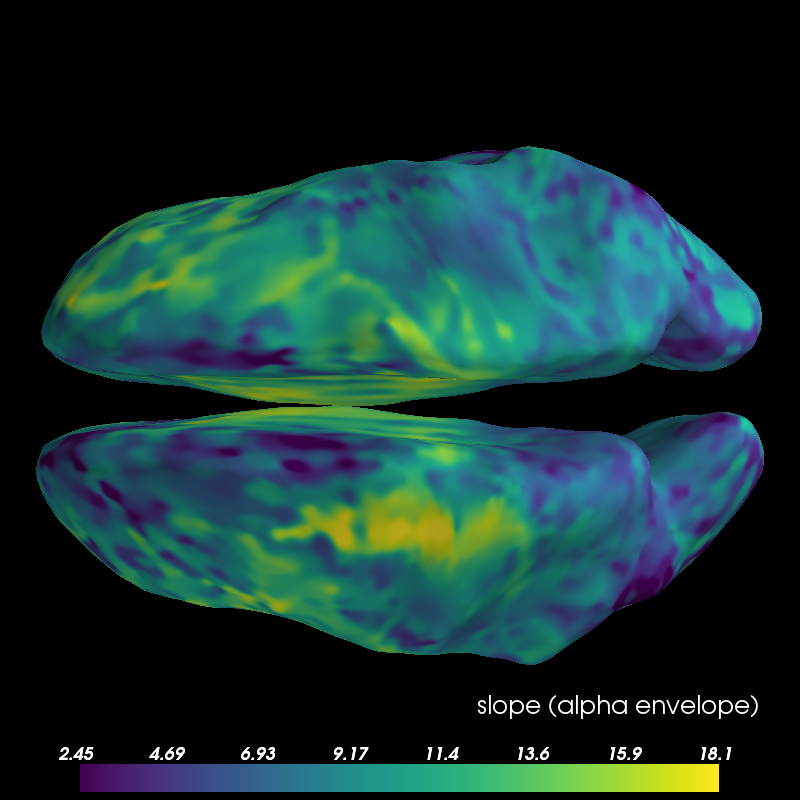

In [82]:
stc_broad_slope._data = np.abs(stc_broad_slope._data)
brain = stc_broad_slope.plot(subject=subject, subjects_dir=subjects_dir,
                             hemi='both',
                             time_label='slope (SCP)',
                             transparent=False,
                             clim=dict(kind='percent', lims=[1, 50, 99]),
                             colormap=cmaps.viridis.colors)
brain.show_view('dorsal')
brain.save_image('paper_figures/scp_slope_subject_demo.png')
Image('paper_figures/scp_slope_subject_demo.png')

Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=2.45e+00 fmid=9.18e+00 fmax=1.81e+01 transparent=0
Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=2.45e+00 fmid=9.18e+00 fmax=1.81e+01 transparent=0


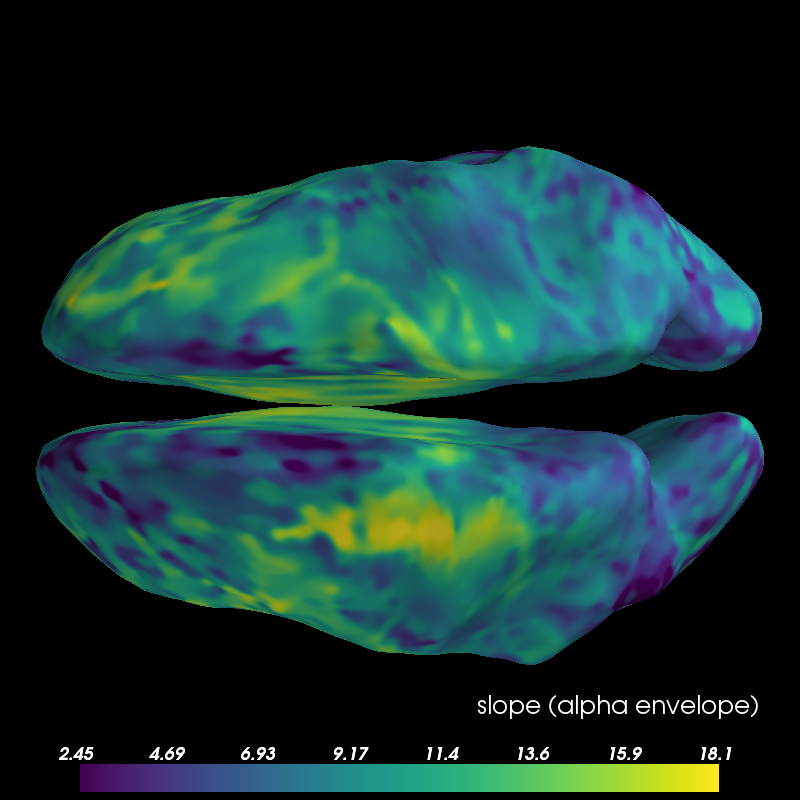

In [81]:
brain = stc_alpha_slope.plot(subject=subject, subjects_dir=subjects_dir,
                             hemi='both',
                             time_label='slope (alpha envelope)',
                             transparent=False,
                             clim=dict(kind='percent', lims=[1, 50, 99]),
                             colormap=cmaps.viridis.colors)
brain.show_view('dorsal')
brain.save_image('tmp.png')
Image('tmp.png')

# Regularization parameter.

In [ ]:
for this_l in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15][::3]:
    lambda2 = 1./this_l **2
    stc_psd = _compute_source_psd(raw, noise_cov=noise_cov, fwd=stack['fwd'], method='dSPM', lambda2=lambda2,
                                  decim=3)

    # plt.plot(np.log10(stc_psd.times), np.log10(stc_psd.data[::10].T));

    psd_mean = np.log10(stc_psd.data).mean(0)
    plt.figure()
    plt.plot(np.log10(stc_psd.times), psd_mean, label='lambda2 %0.3f' % lambda2)
    psd_std = np.log10(stc_psd.data).std(0)
    plt.fill_between(np.log10(stc_psd.times),
                     psd_mean + psd_std,
                     psd_mean - psd_std, alpha=0.3)
    plt.xlim(*np.log10([0.1, 150]))
    plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
    plt.legend()


In [ ]:
psd_mean.shape

In [ ]:
stc_psd = compute_source_psd(raw, noise_cov=noise_cov, fwd=stack['fwd'], method='MNE')

psd_mean = np.log10(stc_psd.data).mean(0)
plt.plot(np.log10(stc_psd.times), psd_mean)
psd_std = np.log10(stc_psd.data).std(0)
plt.fill_between(np.log10(stc_psd.times),
                 psd_mean + psd_std,
                 psd_mean - psd_std, alpha=0.3)
